# MachineHack - Great Indian Hiring Hackathon

This was my first hackathon participation this solution ranked at **#373** on **privateLB** while, **#131** on **publicLB**
**from 5645** participans.

PS: This solution was an overfit but the competition did not allow a 2nd submission and best public score submission was taken for final submission


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost
from scipy import stats

%matplotlib inline

data_path = '..\Data'


In [2]:
train = pd.read_csv(os.path.join(data_path,'Train.csv'), parse_dates= ['InvoiceDate'])
test = pd.read_csv(os.path.join(data_path,'Test.csv'), parse_dates= ['InvoiceDate'])
sample = pd.read_csv(os.path.join(data_path, 'Sample Submission.csv'))

## EDA and Feature Extraction
Note: this notebook just contains the final code used for submission for initial EDA check EDA.ipynb file 

In [3]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


In [4]:
def pre_process(df, mean_qantity=0, mean_up=0):
    """
        Pre-Processing of data to handle outliers and negative values
    """
    #converting all negative values of quantity and unit price in train set
    df['Quantity'] = ((df['Quantity'])**2)**0.5
    df['UnitPrice'] = ((df['UnitPrice'])**2)**0.5
    #Handling outliers by replacing them with mean value
    df.loc[df['Quantity'] >= 10000, 'Quantity'] = mean_qantity
    df.loc[df['UnitPrice'] > 5000, 'UnitPrice'] = mean_up
    return df
def pre_process_test(df, mean_qantity=0):
    df['Quantity'] = ((df['Quantity'])**2)**0.5
    df.loc[df['Quantity'] >= 5000, 'Quantity'] = mean_qantity
    return df

In [5]:
def post_process(df, mean_up=0):
    """
        Post process of the predicted values
    """
    #Converting all negative predictions to positive
    df['UnitPrice'] = ((df['UnitPrice'])**2)**0.5
    df.loc[df['UnitPrice'] > 5000, 'UnitPrice'] = mean_up
    return df

In [6]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['InvoiceDate']
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    return X

In [7]:
def ordered_stats(val):
    """
        Generating some feature based on the quantiy sold
    """
    if val>999:
        #High selling
        return 3
    elif  val>250:
        return 2 #'Moderate_Selling'
    elif  val>100:
        return 1 #'Low_Selling'
    else:
        return 0 #'Minimum_selling'

In [8]:
time_features_train = create_features(train)

In [9]:
train.describe()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
count,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000,284780.000000
mean,9955.394083,1573.386807,2023.955573,12.028468,3.451216,15288.224278,32.823846,12.738064,2.606847,2.856243,7.612922,2010.933910,215.431287,15.030318,30.965479
std,5551.519138,843.604991,1089.812078,295.111588,78.399541,1714.336529,6.743602,2.288886,1.921134,1.121208,3.415785,0.248439,103.382667,8.652114,14.753368
min,0.000000,0.000000,0.000000,-80995.000000,0.000000,12346.000000,0.000000,6.000000,0.000000,1.000000,1.000000,2010.000000,4.000000,1.000000,1.000000
25%,5069.000000,939.000000,1141.000000,2.000000,1.250000,13953.000000,35.000000,11.000000,1.000000,2.000000,5.000000,2011.000000,130.000000,7.000000,19.000000
50%,10310.000000,1521.000000,1987.000000,5.000000,1.950000,15152.000000,35.000000,13.000000,2.000000,3.000000,8.000000,2011.000000,240.000000,15.000000,34.000000
75%,14657.000000,2106.000000,2945.000000,12.000000,3.750000,16794.000000,35.000000,14.000000,4.000000,4.000000,11.000000,2011.000000,310.000000,22.000000,44.000000
max,22188.000000,3683.000000,3895.000000,80995.000000,38970.000000,18287.000000,36.000000,20.000000,6.000000,4.000000,12.000000,2011.000000,357.000000,31.000000,51.000000


In [10]:
train.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35,2011-05-06 16:54:00,16,4,2,5,2011,126,6,18
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35,2011-05-11 07:35:00,7,2,2,5,2011,131,11,19
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35,2011-11-20 13:20:00,13,6,4,11,2011,324,20,46
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35,2011-11-22 12:07:00,12,1,4,11,2011,326,22,47
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35,2011-05-06 09:00:00,9,4,2,5,2011,126,6,18


In [11]:
time_features_test = create_features(test)

In [12]:
test.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22 15:22:00,15,1,1,2,2011,53,22,8
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08 12:46:00,12,2,4,12,2010,342,8,49
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25 13:53:00,13,1,4,10,2011,298,25,43
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27 12:38:00,12,0,2,6,2011,178,27,26
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06 16:14:00,16,6,4,11,2011,310,6,44


In [13]:
train.drop(['InvoiceDate'], axis = 1,inplace = True)
train = pre_process(train, train['Quantity'].median(), train['UnitPrice'].median())

In [14]:
train.drop(['date'], axis = 1, inplace = True)


In [15]:
test.drop(['InvoiceDate', 'date'], axis = 1, inplace=True)

test = pre_process_test(test, test['Quantity'].median())

In [16]:
def feature_generation(df):
    """
        Extraction of features 
    """
    q_bt = df.groupby(['InvoiceNo'], as_index=False).Quantity.agg({'Qt_bought_together': np.sum})
    q_bt.columns = ['InvoiceNo', 'Qt_bought_together']
    df = pd.merge(df, q_bt, how = 'left', on = ['InvoiceNo'])
    
    total_purchase = df.groupby(['CustomerID'], as_index=False).Quantity.agg({'Total_Purchase' : np.sum})
    total_purchase.columns = ['CustomerID', 'Total_purchase']
    df = pd.merge(df, total_purchase, how = 'left', on = ['CustomerID'])
    
    mbw = df.groupby(['weekofyear'], as_index=False).StockCode.agg({'most_bought_sc_weekly': lambda x:x.value_counts().index[0]})
    mbw.columns = ['weekofyear', 'most_bought_sc_weekly']
    df = pd.merge(df, mbw, how = 'left', on = ['weekofyear'])
    
    mbd = df.groupby(['dayofyear'], as_index=False).StockCode.agg({'most_bought_sc_daily': lambda x:x.value_counts().index[0]})
    mbd.columns = ['dayofyear', 'most_bought_sc_daily']
    df = pd.merge(df, mbd, how = 'left', on = ['dayofyear'])
    
    df['SC_Des'] = df['StockCode'].astype(str) + df['Description'].astype(str)
    df['SC_Des'] = df['SC_Des'].astype(int)
    
    df['order_status'] = df['Qt_bought_together'].apply(ordered_stats)
    return df

In [17]:
train = feature_generation(train)
test = feature_generation(test)

In [18]:
train['weekofyear'] = train['weekofyear'].astype(int)
test['weekofyear'] = test['weekofyear'].astype(int)

## Model training 

In [19]:
X = train.drop(['UnitPrice', 'year'], axis = 1)
Y = train['UnitPrice']

In [20]:
test_r = test.drop(['year'], axis = 1)

In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.3, random_state = 3)

In [22]:
params4 = {'colsample_bynode':0.2, 'learning_rate': 0.03, 'max_depth': 20, 'alpha': 10, 'n_estimators' : 333, 'n_jobs': 8,'min_child_weight': 7.3, 'random_state': 3, 'gpu_id':0}
xgb4 = XGBRegressor(**params4, sampling_method = 'gradient_based')

xgb4.fit(X_train, Y_train)
pred_val4 = xgb4.predict(X_val)

from sklearn import metrics
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_val, pred_val4)))

pred_test4 = xgb4.predict(test_r)



RMSE: 18.770852440159924


In [23]:
pred_val_r = (pred_val4**2)**0.5

print('RMSE_of post processed preds:', np.sqrt(metrics.mean_squared_error(Y_val, pred_val_r)))

RMSE_of post processed preds: 18.76473434722462


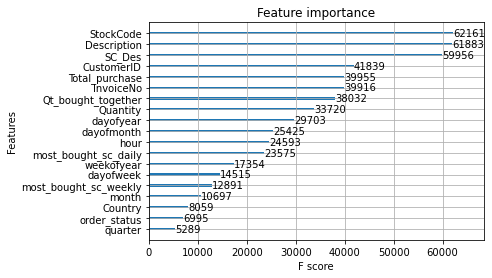

<Figure size 1152x864 with 0 Axes>

In [24]:
xgboost.plot_importance(xgb4)
plt.figure(figsize = (16, 12))
plt.show()

## Creating final submission

In [25]:
Submission_wd = pd.DataFrame(pred_test4, columns = ['UnitPrice'])
Submission_wd = post_process(Submission_wd, Submission_wd['UnitPrice'].mean())
Submission_wd.to_csv('submission_wd.csv')

Submission_wd.describe()

,UnitPrice
count,122049.000000
mean,3.488380
std,13.231874
min,0.001125
25%,1.580019
50%,2.400115
75%,3.774217
max,1812.600342
